# Identificação de Variantes de Mielofibrose

Todos os arquivos estão disponíveis em: https://github.com/Gnoogit/somatico_2024.git.

Para maiores informações sobre este workflow, favor visitar: https://sites.google.com/view/somaticamielofibrose.

## Alunos responsáveis
- Caio Elias (caielias@hotmail.com)
- Clara Gusmão (clara.sabenca.gusmao@gmail.com)
- Gabriel Oliveira (gbnoliveira@gmail.com)
- Gilson Borges (gilson.borges20@gmail.com)
- José Filho (jose.oliveira-filho@unesp.br)
- Kaira Tomaz (kairatomaz@gmail.com)

# Workflow

1. Clonagem do repositório do projeto
2. Instalação dos recursos necessários
3. Filtragem das variáveis de interesse
4. Análise de resultados
5. Conclusão

## 1. Clonagem do repositório do projeto
Com o comando git clone, podemos importar todos os arquivos de uma única vez. O repositório contém as amostras necessárias para análise, assim como scripts extras e arquivos de referência.

In [1]:
%%bash
git clone https://github.com/Gnoogit/somatico_2024.git

Cloning into 'somatico_2024'...
Updating files: 100% (36/36), done.


## 2. Instalação dos recursos necessários

a) Instalar bcftools com o plugin split-vep.

O plugin permite extrair os campos de anotações estruturadas como INFO/CSQ criadas por bcftools/csq ou VEP (em nosso caso VEP).

Mais informações: https://samtools.github.io/bcftools/howtos/plugin.split-vep.html

In [2]:
%%bash
git clone --recurse-submodules https://github.com/samtools/htslib.git
git clone https://github.com/samtools/bcftools.git
cd bcftools
make
make install

Submodule path 'htscodecs': checked out 'ffda7310c4b3292955561d6c3b1743cb82bfe26b'
cd ../htslib && make htslib.pc.tmp
make[1]: Entering directory '/content/htslib'
echo '# Default htscodecs.mk generated by Makefile' > htscodecs.mk
echo 'include $(HTSPREFIX)htscodecs_bundled.mk' >> htscodecs.mk
./hts_probe_cc.sh 'gcc' '-g -Wall -O2 -fvisibility=hidden ' '-fvisibility=hidden' >> htscodecs.mk
sed -e '/^static_libs=/s/@static_LIBS@/-lz -lm -lbz2 -llzma -lcurl/;s#@[^-][^@]*@##g' htslib.pc.in > htslib.pc.tmp
make[1]: Leaving directory '/content/htslib'
cd ../htslib && make htslib_static.mk
make[1]: Entering directory '/content/htslib'
sed -n '/^static_libs=/s/[^=]*=/HTSLIB_static_LIBS = /p;/^static_ldflags=/s/[^=]*=/HTSLIB_static_LDFLAGS = /p' htslib.pc.tmp > htslib_static.mk
make[1]: Leaving directory '/content/htslib'
echo '/* Basic config.h generated by Makefile */' > config.h
echo '#define ENABLE_BCF_PLUGINS 1' >> config.h
echo '#define PLUGIN_EXT ".so"' >> config.h
echo '#define BCFTOOL

Cloning into 'htslib'...
Submodule 'htscodecs' (https://github.com/samtools/htscodecs.git) registered for path 'htscodecs'
Cloning into '/content/htslib/htscodecs'...
Cloning into 'bcftools'...


b) Instalar udocker.

Udocker é uma ferramenta básica para executar containers docker simples em sistemas sem privilégios de root. Esta abordagem de rodar como sudo será apenas utilizada no workflow pois ele foi elaborado para ser utilizado com o Google Colab e não é recomendada.

Em nosso caso, sempre que utilizarmos o comando udocker rodamos com a opção `docker --allow-root`.

Mais informações: https://indigo-dc.github.io/udocker/

In [3]:
%%bash
pip install udocker
udocker --allow-root install

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 1.3 MB/s eta 0:00:00
Info: creating repo: /root/.udocker
Info: udocker command line interface 1.3.12
Info: searching for udockertools >= 1.2.10
Info: installing udockertools 1.2.10
Info: installation of udockertools successful


c) Download imagem do ensembl-vep.

Ensembl vep é um conjunto de ferramentas para predição de impactos de variantes. Neste workflow, usaremos o comando de filtragem do vep, para filtrar as variáveis de interesse. Como o udocker foi instalado, é possível fazer o download da imagem do vep usando `udocker --allow-root pull`.

Mais informações: https://grch37.ensembl.org/info/docs/tools/vep/index.html

In [4]:
%%bash
udocker --allow-root pull ensemblorg/ensembl-vep

Info: downloading layer sha256:e02e5c679e73521d6b5ac34c80b64a6eacd94e8a45b6ec81d077d588be26d840
Info: downloading layer sha256:a048a442ffc7ac34cbd0394d07e68448152bd4c8cf1cfd4ca0af1afb50f38851
Info: downloading layer sha256:a1632579b59519976200219af28eb997519b4e847fbac6783c1c528538faf1dd
Info: downloading layer sha256:0a22368f155fc62715a0b48e19ad7589553fe36e6f787ff68ea87ae7ca9a6a0d
Info: downloading layer sha256:dbf49233d468223f2cf974fa429aa993845c84724c2f9f788cef984641876cf9
Info: downloading layer sha256:19287231d48f431f90546169f1643b6f6c56eff982929752a14cdb57708e8f6a
Info: downloading layer sha256:7c0cc344b67da8e99d10a49719a2eb1e0e1a7b2e2c5e01d08c28c55732bbb563
Info: downloading layer sha256:f2fc22b2df3c174bb16fc1501475d6fe4188e6ad30bdfe55209bde856d7bb8b9
Info: downloading layer sha256:0b6c4557cb6b12f24f4954443c84ee170325b5dda190307c78043a05b05907c0
Info: downloading layer sha256:4f4fb700ef54461cfa02571ae0db9a0dc1e0cdb5577484a6d75e68dc38e8acc1
Info: downloading layer sha256:2d1d2b4fa

## 3. Filtragem das variáveis de interesse

A filtragem das variáveis é executada no script vep-gc.sh. O arquivo Myelofibrosis.txt possui uma lista dos genes de interesse. Para mais informações sobre o script, favor consultar o script completo no repositório.

(Neste workflow, foram utilizadas as amostras do projeto LMA Brasil. Os arquivos VCF do projeto foram convertidos previamente da versão do genoma hg19 para hg38 utilizando o programa gatk LiftoverVcf com as posições hg19ToHg38.over.chain da UCSC.)

In [5]:
%%bash
sh somatico_2024/vep-gc.sh Myelofibrosis.txt

STARTING SAMPLE N:WP048
 
 ****************************************************************************** 
 *                                                                            * 
 *               STARTING a7eb3269-1896-3563-a9e3-7e406853e39d                * 
 *                                                                            * 
 ****************************************************************************** 
 executing: filter_vep
WP048 - DONE!
STARTING SAMPLE N:WP056
 
 ****************************************************************************** 
 *                                                                            * 
 *               STARTING 1a9630a6-5cfd-3de9-ab8b-886e9d79c2c5                * 
 *                                                                            * 
 ****************************************************************************** 
 executing: filter_vep
WP056 - DONE!
STARTING SAMPLE N:WP060
 
 *************************************


-------------------- WARNING ----------------------
MSG: The script 'filter_vep' couldn't find the VEP annotations INFO field CSQ in 149 lines of the input file
FILE: src/ensembl-vep/filter_vep LINE: 345
CALLED BY: src/ensembl-vep/filter_vep  LINE: 55
Date (localtime)    = Fri Jan 12 14:45:04 2024
Ensembl API version = 111
---------------------------------------------------

-------------------- WARNING ----------------------
MSG: The script 'filter_vep' couldn't find the VEP annotations INFO field CSQ in 133 lines of the input file
FILE: src/ensembl-vep/filter_vep LINE: 345
CALLED BY: src/ensembl-vep/filter_vep  LINE: 55
Date (localtime)    = Fri Jan 12 14:45:31 2024
Ensembl API version = 111
---------------------------------------------------

-------------------- WARNING ----------------------
MSG: The script 'filter_vep' couldn't find the VEP annotations INFO field CSQ in 146 lines of the input file
FILE: src/ensembl-vep/filter_vep LINE: 345
CALLED BY: src/ensembl-vep/filter_vep  

## 4. Análise de resultados

a) Utilizamos então a ferramenta pandas no código abaixo para gerar uma tabela unificada com as variáveis de interesse a partir das saídas do script vep-gc.sh. Pandas é uma ferramenta para análise e manipulação de dados em Python.

Mais informações: https://pandas.pydata.org/

In [131]:
import pandas as pd
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

output_folder = '/content/somatico_2024/my_samples/vep_output/'
output_path = '/content/df_merged.csv'

dataframes = []

for final_outputs in os.listdir(output_folder):
    if final_outputs.endswith('.tsv'):

        output_pathway = os.path.join(output_folder, final_outputs)
        df = pd.read_csv(output_pathway, sep='\t', index_col=False)
        df['Sample'] = final_outputs.split('_')[1]
        dataframes.append(df)

df_merged = pd.concat(dataframes, ignore_index=True)
df_merged.to_csv(output_path, index=False)

b) Com a tabela unificada, é possível gerar um gráfico que mostra o número de variantes que cada amostra apresenta. As amostras que não aparecem no gráfico não possuem variantes de interesse.

De todas as amostras analisadas, apenas 8 amostras apresentaram alguma variante de interesse nos genes em questão, sendo a amostra WP276 a amostra com o maior número de variantes.

<Axes: title={'center': 'Variants per sample'}, xlabel='Sample'>

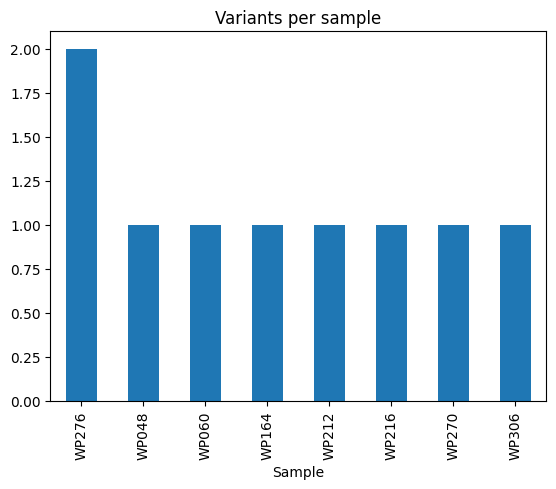

In [132]:
df_merged_sample_chart = df_merged.value_counts("Sample")
df_merged_sample_chart.plot.bar(x='Sample', title='Variants per sample')

c) Com a mesma tabela, é possível gerar também um gráfico que mostra a distribuição das variantes de interesse para cada gene. Alguns genes não aparecem no gráfico pois não foram encontradas variantes de interesse nos mesmos, dentre as amostras analisadas.

De todos os genes em questão, foram encontradas variantes em apenas 5 deles, com o gene TP53 apresentando o maior número de variantes.

<Axes: title={'center': 'Distribution of variants per gene'}>

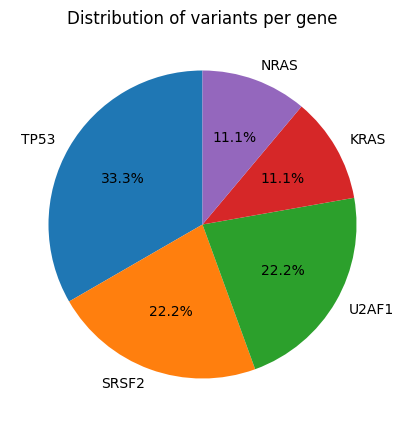

In [133]:
df_merged_chr_chart = df_merged.value_counts("SYMBOL")
df_merged_chr_chart.plot.pie(y='SYMBOL', figsize=(5, 5), autopct='%1.1f%%', startangle=90, title='Distribution of variants per gene')

d) Com um pouco de manipulação em nossa tabela, conseguimos gerar um gráfico que relaciona a patogenicidade das variantes de acordo com os genes estudados. Alguns genes não aparecem no gráfico pois não foram encontradas variantes de interesse nos mesmos, dentre as amostras analisadas.

Dos genes em questão, encontramos anotações de patogenicidade para os genes KRAS, NRAS e TP53.

<Axes: title={'center': 'Pathogenicity of variants per gene'}, xlabel='SYMBOL'>

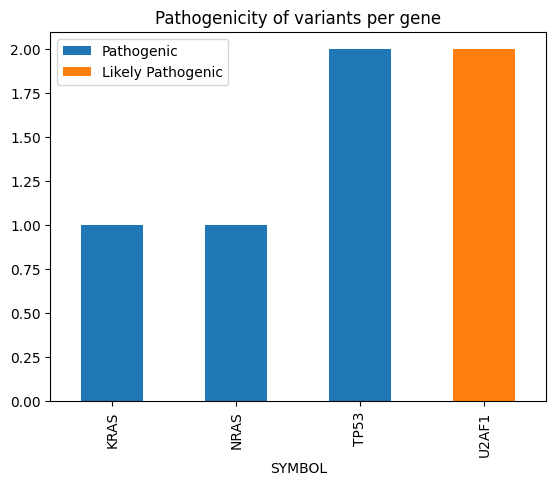

In [248]:
clin_sig_split = pd.DataFrame()
clin_sig_split_and = pd.DataFrame()
clin_sig_split_or = pd.DataFrame()

clin_sig_split_and = df_merged['CLIN_SIG'].str.split('&',expand=True)
for col1 in clin_sig_split_and:
  if clin_sig_split_and[col1].str.contains('/').any():
    clin_sig_split_or = clin_sig_split_and[col1].str.split('/',expand=True)
    for col2 in clin_sig_split_or:
      clin_sig_split['CLIN_SIG_'+str(len(clin_sig_split_and.columns)+col2+1)] = clin_sig_split_or[col2]
  else:
    clin_sig_split['CLIN_SIG_'+str(col1)] = clin_sig_split_and[col1]

clin_sig_split_pathogenic = clin_sig_split.where(clin_sig_split=='pathogenic')
clin_sig_split_likely_pathogenic = clin_sig_split.where(clin_sig_split=='likely_pathogenic')

df_merged_clin_chart = pd.DataFrame()
df_merged_clin_chart['SYMBOL'] = df_merged['SYMBOL']
df_merged_clin_chart['Pathogenic'] = clin_sig_split_pathogenic[clin_sig_split_pathogenic.columns[0:]].apply(lambda x: int(bool(''.join(x.dropna().astype(str)))),axis=1)
df_merged_clin_chart['Likely Pathogenic'] = clin_sig_split_likely_pathogenic[clin_sig_split_likely_pathogenic.columns[0:]].apply(lambda x: int(bool(''.join(x.dropna().astype(str)))),axis=1)
df_merged_clin_chart['Likely Pathogenic'] = df_merged_clin_chart['Likely Pathogenic'] - ( df_merged_clin_chart['Pathogenic'] * df_merged_clin_chart['Likely Pathogenic'] )

df_merged_clin_chart[( df_merged_clin_chart['Pathogenic'] != 0 ) | ( df_merged_clin_chart['Likely Pathogenic'] != 0 )].groupby('SYMBOL').sum().plot.bar(stacked=True, title='Pathogenicity of variants per gene')

## 5. Conclusão

Podemos concluir que, apesar do baixo número de variantes encontradas, nossa análise está de acordo com a literatura pois demonstra alterações patogênicas nos genes KRAS, NRAS e TP53 e provavelmente patogênicas no gene U2AF1.